# DETR football training

## TODO
- [ ] uprządkuj dataset - niepotrzebnie go przerabiałeś bo metoda transform przyjmuje obiekty w formacie coco podobnym do tego w dataset roboflow
- [ ] załaduj większy set danych treningowych od Mikołaja


## Prep

In [16]:
%pip install -U -q datasets transformers[torch] evaluate timm albumentations accelerate roboflow


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [42]:
#checkpoint = "facebook/detr-resnet-50-dc5" # DETR
checkpoint = "SenseTime/deformable-detr" #Deformable DETR
my_checkpoint = "deformable-detr-football-finetuned"


Little helper to check if we are in Google Colab and to handle imports

In [18]:
try:
    from google.colab import drive
    from google.colab import userdata
    in_colab = True
except ImportError:
    from dotenv import load_dotenv
    in_colab = False

## Dataset

### Download dataset

In [19]:
import os
from roboflow import Roboflow


dataset_version = 1
dataset_location = "../data/training"

if in_colab:
     rf_api_key = userdata.get("ROBOFLOW_API_KEY")
else:
    load_dotenv(dotenv_path='../config/.env')
    rf_api_key = os.getenv("ROBOFLOW_API_KEY")

rf = Roboflow(api_key=rf_api_key)
project = rf.workspace("sport-cv").project("football-players-detection-3zvbc-fynld")
version = project.version(2)
robo_dataset = version.download("coco", location=dataset_location)
print("loaded dataset to", dataset_location)



loading Roboflow workspace...
loading Roboflow project...
loaded dataset to ../data/training


In [ ]:
import json
from datasets import Dataset, DatasetDict
from PIL import Image
import numpy as np
import os

def load_coco_dataset_with_images(json_file, dataset_base_path, split):
    # Load the JSON data
    with open(json_file, 'r', encoding='utf-8') as f:
        coco_data = json.load(f)

    # Extract images and annotations
    images = coco_data['images']
    annotations = coco_data['annotations']
    categories = coco_data['categories']

    # Determine the split (train, valid, test) from the json file name
    print("split", split)
    images_dir = os.path.join(dataset_base_path, split)
    # Create a mapping from image_id to annotations
    image_id_to_annotations = {}
    for ann in annotations:
        image_id = ann['image_id']
        if image_id not in image_id_to_annotations:
            image_id_to_annotations[image_id] = []
        image_id_to_annotations[image_id].append(ann)
    
    # Prepare the dataset
    data = []
    for img in images:
        img_id = img['id']
        img_filename = img['file_name']
        img_annotations = image_id_to_annotations.get(img_id, [])
        
        img_path = os.path.join(images_dir, img_filename)
        try:
            image = Image.open(img_path).convert("RGB")
            
            # Przygotuj obiekty w odpowiednim formacie
            objects = {
                'id': [],
                'area': [],
                'bbox': [],
                'category': []
            }
            
            for ann in img_annotations:
                objects['id'].append(ann['category_id'])
                objects['area'].append(ann['area'])
                objects['bbox'].append(ann['bbox'])
                objects['category'].append(categories[ann['category_id']]['name']) 
                        
            print(objects['bbox'])

            data.append({
                'image': image,
                'image_id': img_id,
                'width': img['width'],
                'height': img['height'],
                'objects': objects
            })
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    # Create a Dataset object z nową strukturą
    return Dataset.from_dict({
        'image': [item['image'] for item in data],
        'image_id': [item['image_id'] for item in data],
        'width': [item['width'] for item in data],
        'height': [item['height'] for item in data],
        'objects': [item['objects'] for item in data]
    })

# Load each split
dataset_base_path = robo_dataset.location  # Using your existing dataset_location variable
train_json = os.path.join(dataset_base_path, "train", "_annotations.coco.json")
val_json = os.path.join(dataset_base_path, "valid", "_annotations.coco.json")
test_json = os.path.join(dataset_base_path, "test", "_annotations.coco.json")

# Load datasets for each split
train_dataset = load_coco_dataset_with_images(train_json, dataset_base_path, 'train')
val_dataset = load_coco_dataset_with_images(val_json, dataset_base_path, 'valid')
test_dataset = load_coco_dataset_with_images(test_json, dataset_base_path, 'test')

# Combine into a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

dataset

split train
images_dir /Users/kamil/Desktop/AI/ComputerVision/laba-cv-project/data/training/train
[[1117, 299, 17.76, 33.9], [947, 324, 16, 36], [834, 357, 22.24, 43.18], [584, 398, 22.35, 51.67], [929, 291, 15, 35], [706, 337, 17, 32], [1002, 330, 20, 43], [681, 366, 23, 40], [1514, 327, 15, 38], [264, 387, 21, 46], [520, 422, 20.51, 44.06], [555, 381, 19, 46], [1248, 364, 17, 40], [1446, 442, 19, 54], [942, 420, 16, 49], [711, 514, 19, 56], [1372, 510, 21, 57], [1666, 410, 26, 52], [883, 419, 19, 51], [1116, 545, 36, 55], [1221, 323, 10.32, 10], [1144, 286, 23.64, 37.72], [978, 276, 16.29, 34.98], [781, 269, 16, 30.92]]
[[1086, 220, 18.76, 34.14], [372, 287, 15.94, 42.35], [1487, 271, 19, 39], [1122, 246, 14, 37], [494, 314, 16, 43], [303, 333, 20, 47], [427, 306, 17, 42], [709, 396, 24, 51], [1141, 305, 17, 43], [1334, 296, 23, 42], [352, 339, 21, 49], [583, 385, 22, 53], [1444, 484, 24, 64], [982, 285, 25, 39], [269, 480, 21, 59], [927, 284, 28, 38], [527, 379, 31, 51], [1062, 484,

KeyboardInterrupt: 

In [24]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

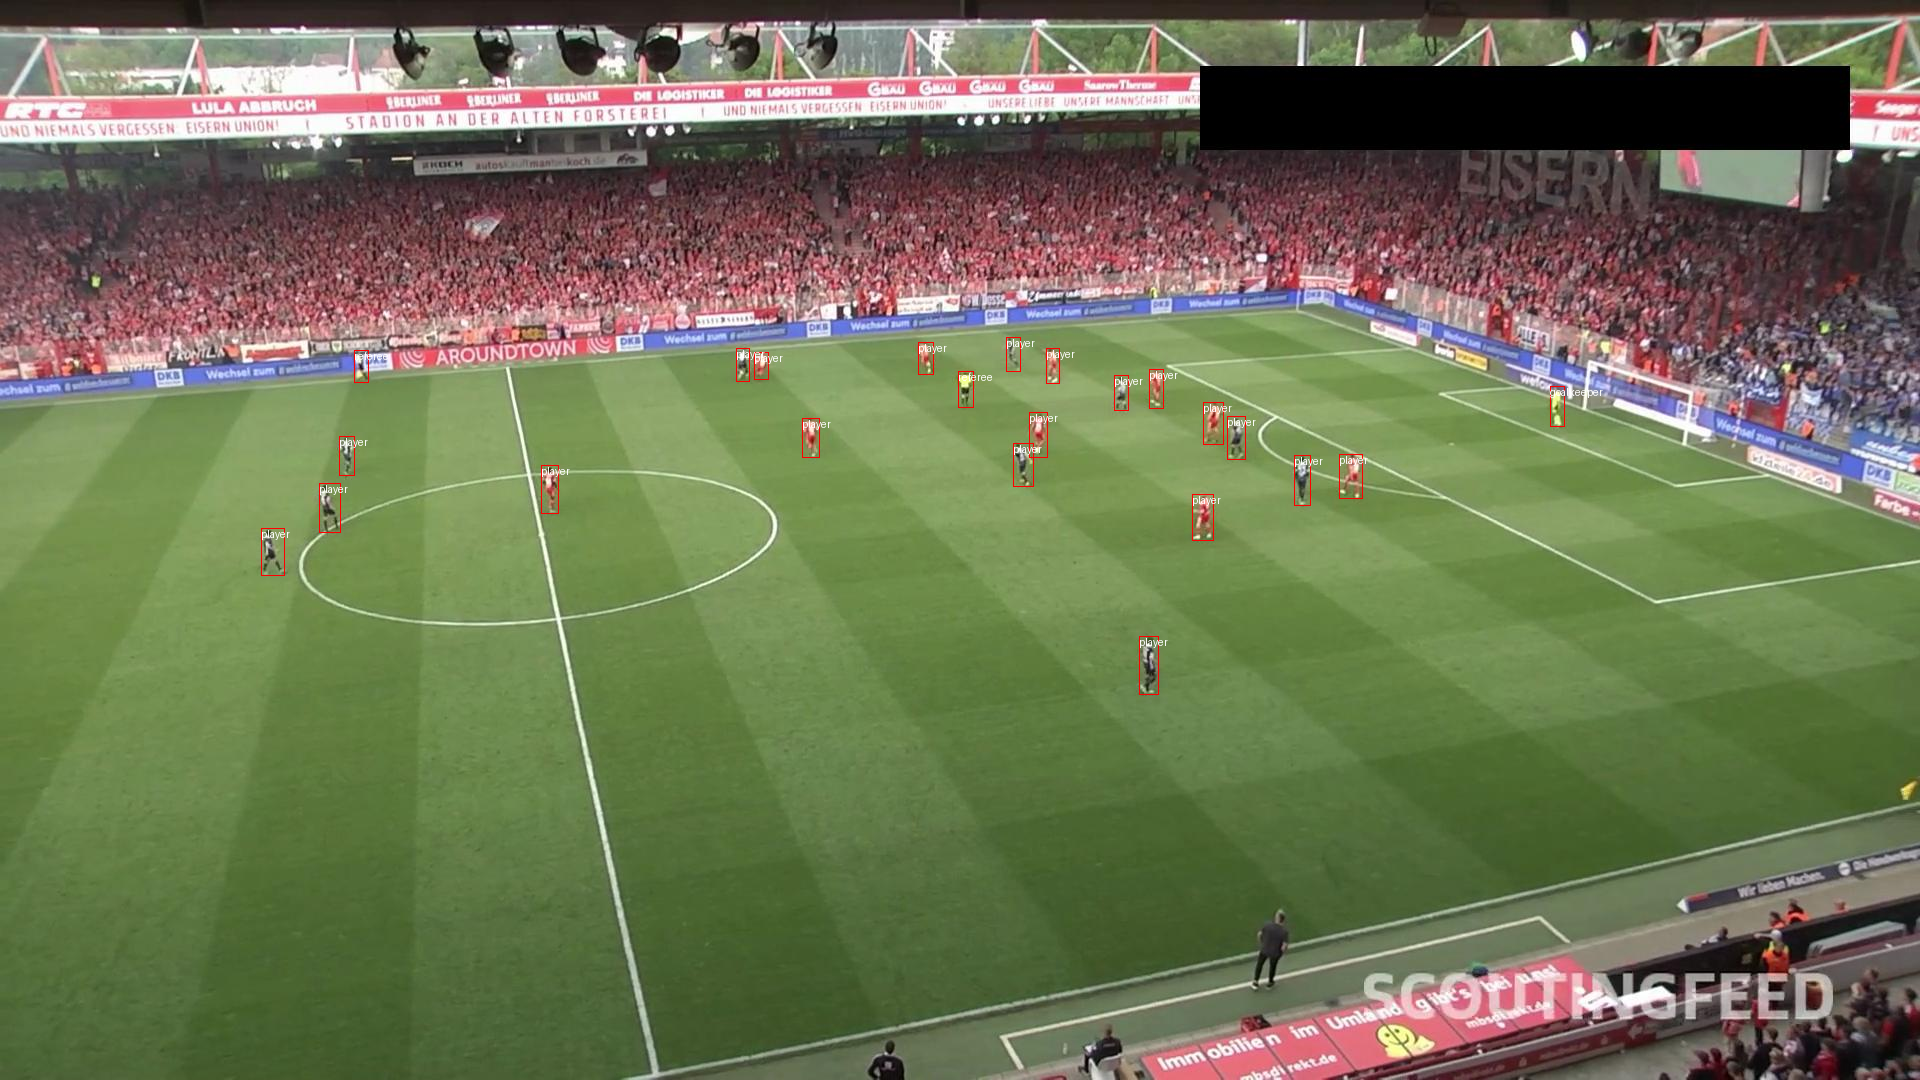

In [25]:
import numpy as np
from PIL import Image, ImageDraw


def draw_image_from_idx(dataset, idx):
    sample = dataset[idx]
    image = sample["image"]
    annotations = sample["objects"]
    draw = ImageDraw.Draw(image)
    width, height = sample["width"], sample["height"]

    for i in range(len(annotations["id"])):
        box = annotations["bbox"][i]
        class_idx = annotations["id"][i]
        x, y, w, h = tuple(box)
        if max(box) > 1.0:
            x1, y1 = int(x), int(y)
            x2, y2 = int(x + w), int(y + h)
        else:
            x1 = int(x * width)
            y1 = int(y * height)
            x2 = int((x + w) * width)
            y2 = int((y + h) * height)
        draw.rectangle((x1, y1, x2, y2), outline="red", width=1)
        draw.text((x1, y1), annotations["category"][i], fill="white")
    return image


import random
random_idx = random.randint(0, len(train_dataset) - 1)
draw_image_from_idx(dataset=train_dataset, idx=random_idx)

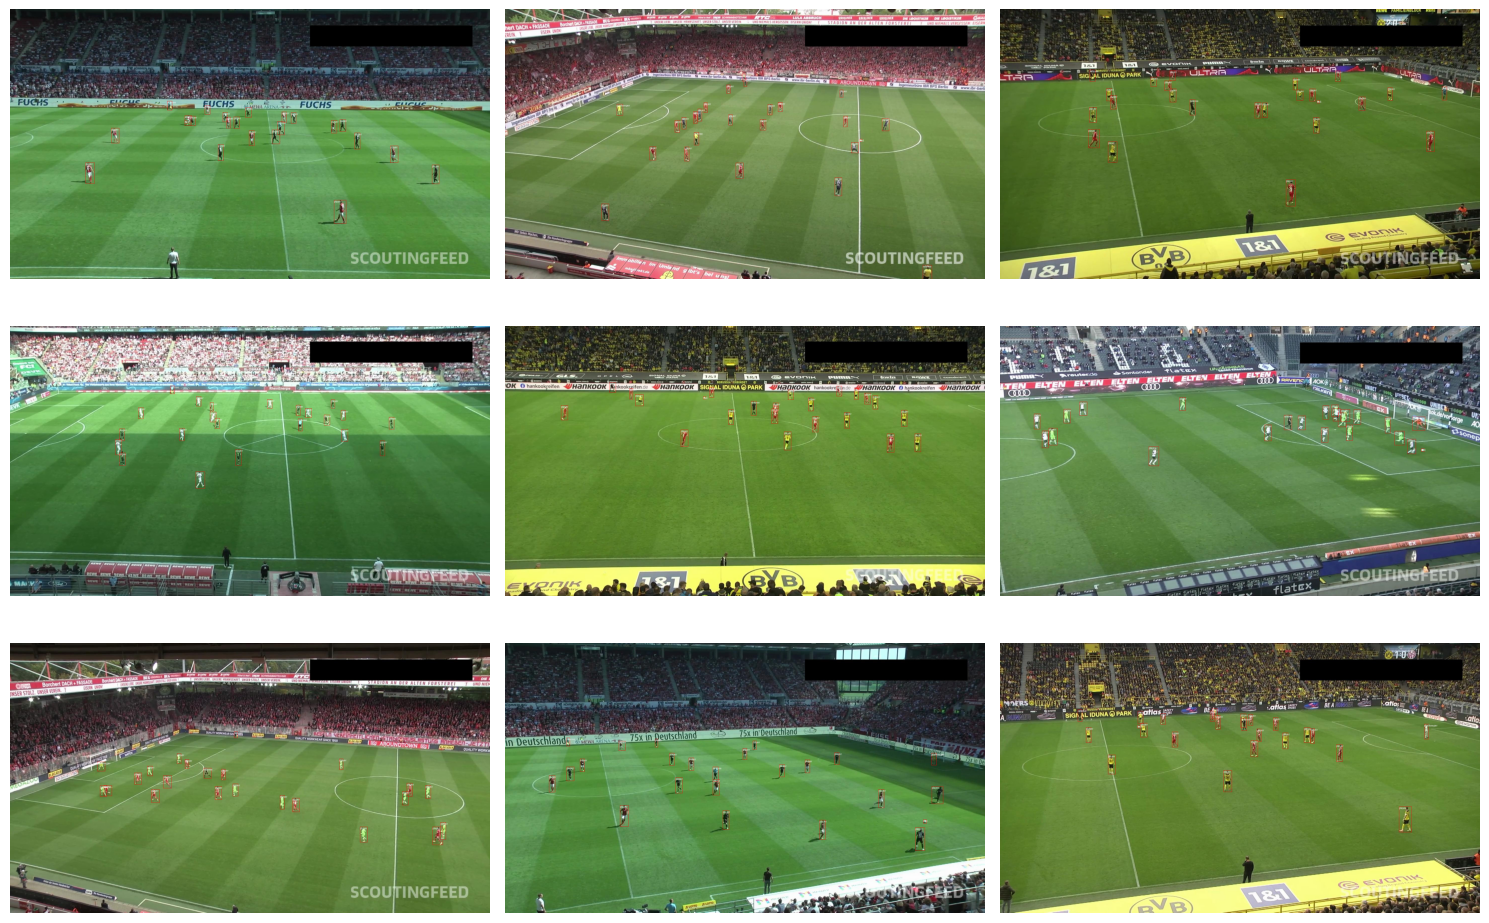

In [26]:
import matplotlib.pyplot as plt


import random

def plot_images(dataset, num_images=9):
    indices = random.sample(range(len(dataset)), num_images)
    num_rows = num_images // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

    for i, idx in enumerate(indices):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = draw_image_from_idx(dataset, idx)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


# Now use the function to plot images
plot_images(train_dataset)


### Preprocessing the Dataset

In [43]:
from transformers import AutoImageProcessor

checkpoint = checkpoint
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/305 [00:00<?, ?B/s]

In [40]:
import albumentations
import numpy as np

transform = albumentations.Compose(
    [
        albumentations.Resize(480, 480),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
        bbox_params=albumentations.BboxParams(
        format="coco",
        label_fields=["category"],
        clip=True,
        check_each_transform=True #TODO: sprawdzić działanie na False
    ),
)

Once we initialize all the transformations, we need to make a function which formats the annotations and returns the a list of annotation with a very specific format.

This is because the image_processor expects the annotations to be in the following format: {'image_id': int, 'annotations': List[Dict]}, where each dictionary is a COCO object annotation.

In [29]:
def formatted_anns(image_id, category, area, bbox):
    annotations = []
    for i in range(0, len(category)):
        new_ann = {
            "image_id": image_id,
            "category_id": category[i],
            "isCrowd": 0,
            "area": area[i],
            "bbox": list(bbox[i]),
        }
        annotations.append(new_ann)

    return annotations

In [30]:
# transforming a batch

def transform_aug_ann(examples):
    print("examples", examples)
    image_ids = examples["image_id"]
    images, bboxes, area, categories = [], [], [], []
    for image, objects in zip(examples["image"], examples["objects"]):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image=image, bboxes=objects["bbox"], category=objects["id"])

        area.append(objects["area"])
        images.append(out["image"])
        bboxes.append(out["bboxes"])
        categories.append(out["category"])

    targets = [
        {"image_id": id_, "annotations": formatted_anns(id_, cat_, ar_, box_)}
        for id_, cat_, ar_, box_ in zip(image_ids, categories, area, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")

In [31]:
# Apply transformations for both train and test dataset

train_dataset_transformed = train_dataset.with_transform(transform_aug_ann)
test_dataset_transformed = test_dataset.with_transform(transform_aug_ann)

A collate_fn is responsible for taking a list of samples from a dataset and converting them into a batch suitable for model’s input format.

In general a DataCollator typically performs tasks such as padding, truncating etc. In a custom collate function, we often define what and how we want to group the data into batches or simply, how to represent each batch.

Data collator mainly puts the data together and then preprocesses them. Let’s make our collate function.

In [34]:
def collate_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["pixel_mask"] = encoding["pixel_mask"]
    batch["labels"] = labels
    return batch

## Training

In [35]:
from huggingface_hub import login
try:
    from google.colab import userdata
    login(token=userdata.get('HF_TOKEN'))
except ImportError:
    login()

In [44]:
from transformers import AutoModelForObjectDetection

id2label = {0: "football-players-detection", 1: "ball", 2: "goalkeeper", 3: "player", 4: "referee"}
label2id = {v: k for k, v in id2label.items()}


model = AutoModelForObjectDetection.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

config.json:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/161M [00:00<?, ?B/s]

Some weights of the model checkpoint at SenseTime/deformable-detr were not used when initializing DeformableDetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeformableDetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeformableDetrForObjectDetection wer

In [ ]:
from transformers import TrainingArguments
from transformers import Trainer

# Define the training arguments

training_args = TrainingArguments(
    output_dir=my_checkpoint,
    per_device_train_batch_size=8,
    num_train_epochs=5,
    fp16=True,
    logging_steps=100,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_steps=100,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
)

# Define the trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset_transformed,
    eval_dataset=test_dataset_transformed,
    tokenizer=image_processor,
)

trainer.train()


## Testing


If you save the model to the hub, you need to change the model to your own username and the name of the model.

In [ ]:
import requests
from transformers import pipeline

# make the object detection pipeline

obj_detector = pipeline(
    "object-detection", 
    model= my_checkpoint, 
    threshold=0.3
)
results = obj_detector(train_dataset[0]["image"])

print(results)

In [ ]:
image = train_dataset[0]["image"]
image

In [23]:
from PIL import ImageFont

def plot_results(image, results, threshold=0.7):
    image = Image.fromarray(np.uint8(image))
    draw = ImageDraw.Draw(image)
    for result in results:
        score = result["score"]
        label = result["label"]
        box = list(result["box"].values())
        if score > threshold:
            x, y, x2, y2 = tuple(box)
            draw.rectangle((x, y, x2, y2), outline="red", width=1)
            draw.text(
                (x + 0.5, y - 0.5),
                text=str(label),
                fill="green" if score > 0.7 else "red",
                font=ImageFont.load_default(size=16) # Increased font size
            )
    return image

In [ ]:
plot_results(image, results, threshold=0.5)


In [ ]:
def predict(image, pipeline, threshold=0.1):
    results = pipeline(image)
    return plot_results(image, results, threshold)


# Let's test for another test image

img = test_dataset[0]["image"]
predict(img, obj_detector)

In [ ]:
from tqdm.auto import tqdm


def plot_images(dataset, indices):
    """
    Plot images and their annotations.
    """
    indices = random.sample(range(len(dataset)), len(indices))
    num_rows = len(indices) // 3
    num_cols = 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))


    for i, idx in tqdm(enumerate(indices), total=len(indices)):
        row = i // num_cols
        col = i % num_cols

        # Draw image
        image = predict(dataset[idx]["image"], obj_detector)

        # Display image on the corresponding subplot
        axes[row, col].imshow(image)
        axes[row, col].axis("off")

    plt.tight_layout()
    plt.show()


plot_images(test_dataset, range(6))